In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import builtins
builtins.NAMING = "new"


from plotting_src.header_settings import *
from plotting_src.read_ggp_run import * 
from simulations.cells_simulation import * 

from plotting_src.cells_utils import *
from plotting_src.read_utils import *


%config InlineBackend.figure_format ='retina'

header_setting.py: using new naming


In [2]:
input_dir =     "../../fluctuations_paper_data/mother_machine_data_sets/"
# raw_input_dir = "../../fluctuations_paper_data/raw_curated_data_complete_cycles/"
prediction_files = get_input_files(input_dir, keyword="prediction")

In [3]:
def get_metas(prediction_files):
    samples = pd.DataFrame(index=prediction_files, columns=["date", "sample", "promoter", "condition", "replicate"])
    for pf in prediction_files:
        sample = "_".join(pf.split("/")[-1].split(".")[0].split("_")[:3])
        samples.loc[pf,"sample"] = sample
        samples.loc[pf,"condition"] = sample.split("_")[0]
        samples.loc[pf,"promoter"] = sample.split("_")[1]
        samples.loc[pf,"date"] = sample.split("_")[2]

    condition_promoter_tuples = []
    for pf in prediction_files:
        condition_promoter_tuple = "_".join(samples.loc[pf,"sample"].split("_")[:2])
        if condition_promoter_tuple in condition_promoter_tuples:
            samples.loc[pf,"replicate"] = "2"
        else:
            samples.loc[pf,"replicate"] = "1"
        condition_promoter_tuples.append(condition_promoter_tuple)

    return samples.to_dict('index')


def calc_log_concentration(cells):
    for i, cell in enumerate(cells):
        c = cell.gfp/np.exp(cell.log_length)
        if np.any(c<0):
            print(c)
        cells[i].log_concentration = np.log(c)
        cells[i].log1_concentration = np.log(c+1)
        cells[i].concentration = c
    return cells

def get_mean_growth_rate(cells):
    mean_lambda = np.sum(np.concatenate([np.array(cell.lt)/np.array(cell.cov_ll) for cell in cells])) \
                /np.sum(np.concatenate([1./np.array(cell.cov_ll) for cell in cells]))
    return mean_lambda


def get_integration_file(pf, setting):
    parent_dir = os.path.join(*pf.split("/")[:-1])
    sample = '_'.join(pf.split('/')[-1].split('_')[:3])
    return os.path.join(*parent_dir.split("/")[:-1], "integration",sample, setting, sample+"_"+setting+'.csv')


def calc_cv(means, covs=None):
    if np.any(covs==None):
        return np.std(means)/np.mean(means)
    else:
        return np.sqrt(np.sum(np.power(means, 2) + covs)/len(means) - np.mean(means)**2)/np.mean(means)

def calc_std(means, covs=None):
    if np.any(covs==None):
        return np.std(means)
    else:
        return np.sqrt(np.sum(np.power(means, 2) + covs)/len(means) - np.mean(means)**2)
    
def get_cells(samples):
    for pf in samples.keys():
        print(pf.split("/")[-1])

        samples[pf]["cells"] = calc_log_concentration(ggp_df2cells(read_ggp_csv(pf)))
        samples[pf]["ggp_cells"] = calc_log_concentration(df2ggp_cells(read_ggp_csv(pf)))
        for i in ["l", "q"]:
            zi = "mean_{:s}".format(i)
            zi_cov = "cov_{:s}{:s}".format(i, i)

            zi_coll_prediction = np.concatenate([cell.__dict__[zi] for cell in samples[pf]["ggp_cells"]])
            zi_coll_prediction_err = np.concatenate([cell.__dict__[zi_cov] for cell in samples[pf]["ggp_cells"]])
            samples[pf]["{:s}_mean".format(i)] = np.mean(zi_coll_prediction)
            samples[pf]["{:s}_cv".format(i)] = calc_cv(zi_coll_prediction, zi_coll_prediction_err)
            samples[pf]["{:s}_std".format(i)] = calc_std(zi_coll_prediction, zi_coll_prediction_err)

        samples[pf]["mean_growth_rate"] = get_mean_growth_rate(samples[pf]["cells"])
        samples[pf]["cells_no_div_no_prod_noise"] = calc_log_concentration(df2cells(read_ggp_csv(get_integration_file(pf, "no_div_no_prod_noise"))))

        for s in ['1.2', '1','0.8','0.6','0.4','0.2','0']:
            samples[pf]["cells_"+s] = calc_log_concentration(df2cells(read_ggp_csv(get_integration_file(pf, "alphaq_"+s))))

    return samples

samples = get_metas(sort_by_condition(prediction_files))
samples = get_cells(samples)

acetate005_hi1_20230228_autofl_corrected_f01234578910_b_prediction.csv
acetate005_hi3_20230228_autofl_corrected_f01234578910_b_prediction.csv
acetate005_med2_20230223_autofl_corrected_f01234578910_b_prediction.csv
acetate005_med3_20230428_autofl_corrected_f01234578910_b_prediction.csv
acetate005_rplN_20230228_autofl_corrected_f01234578910_b_prediction.csv
acetate005_rrnB_20230228_autofl_corrected_f01234578910_b_prediction.csv
glycerol040_hi1_20190515_autofl_corrected_f01234578910_b_prediction.csv
glycerol040_hi3_20190529_autofl_corrected_f01234578910_b_prediction.csv
glycerol040_med2_20190515_autofl_corrected_f01234578910_b_prediction.csv
glycerol040_med3_20190529_autofl_corrected_f01234578910_b_prediction.csv
glycerol040_rplN_20190529_autofl_corrected_f01234578910_b_prediction.csv
glycerol040_rrnB_20230413_autofl_corrected_f01234578910_b_prediction.csv
glucose020_hi1_20190515_autofl_corrected_f01234578910_b_prediction.csv
glucose020_hi3_20190529_autofl_corrected_f01234578910_b_predict

In [4]:
def filter_dict(samples, filter_key=None):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        if filter_key in sample_name:
            new_samples[pf] = samples[pf]
    return new_samples

def filter_dict_not(samples, *filter_keys):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        remove = np.any([filter_key in sample_name for filter_key in filter_keys])
        if not remove:
            new_samples[pf] = samples[pf]
    return new_samples

def get_replicate(samples, repl="1"):
    new_samples = {}
    for pf in samples.keys():
        
        if samples[pf]["replicate"] == repl :
            new_samples[pf] = samples[pf]
    return new_samples

first_replicates = filter_dict_not(get_replicate(samples), "6300") 


In [5]:
def is_first_cell_in_lineage(cell, cells):
    pid = cell.parent_id
    for c in cells:
        if c.cell_id == pid:
            return False
    return True


############# get * concentrations  #############
def get_log_concentrations(cells):
    return np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

def get_log1_concentrations(cells):
    return np.concatenate([cell.log1_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

def get_finite_log_concentrations(cells):
    lc = np.concatenate([cell.log_concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return lc[np.isfinite(lc)]

def get_concentrations(cells):
    return np.concatenate([ cell.concentration for cell in cells if not is_first_cell_in_lineage(cell, cells)])

############# get log gfp  #############
def get_finite_log_gfp(cells):
    g = np.concatenate([np.log(cell.gfp) for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return g[np.isfinite(g)]


############# get gfp  #############
def get_gfp(cells):
    g = np.concatenate([cell.gfp for cell in cells if not is_first_cell_in_lineage(cell, cells)])
    return g

############# get concentration std  #############
def get_concentration_std(cells):
    return np.std( get_concentrations(cells) )

### Label
def get_q_scale_label(s):
    label = { s: r"${:s}$".format(s) for i,s in enumerate(['1.2', '1','0.8','0.6','0.4','0.2','0'])}
    label['1'] = '1'
    s = s.split("_")[-1]
    return r"$\alpha_q$=" + label[s]

In [6]:


# alpha_by_setting = {"cells_"+s: i*0.1 +0.2 for i,s in enumerate(["1", "0.32", "0.1", "0.032", "0.01", "0.0032", "0.001"])}
alpha_by_setting = {"cells_"+s: 1- i*0.12 for i,s in enumerate(['1.2', '1','0.8','0.6','0.4','0.2','0'])}

alpha_by_setting

{'cells_1.2': 1.0,
 'cells_1': 0.88,
 'cells_0.8': 0.76,
 'cells_0.6': 0.64,
 'cells_0.4': 0.52,
 'cells_0.2': 0.4,
 'cells_0': 0.28}

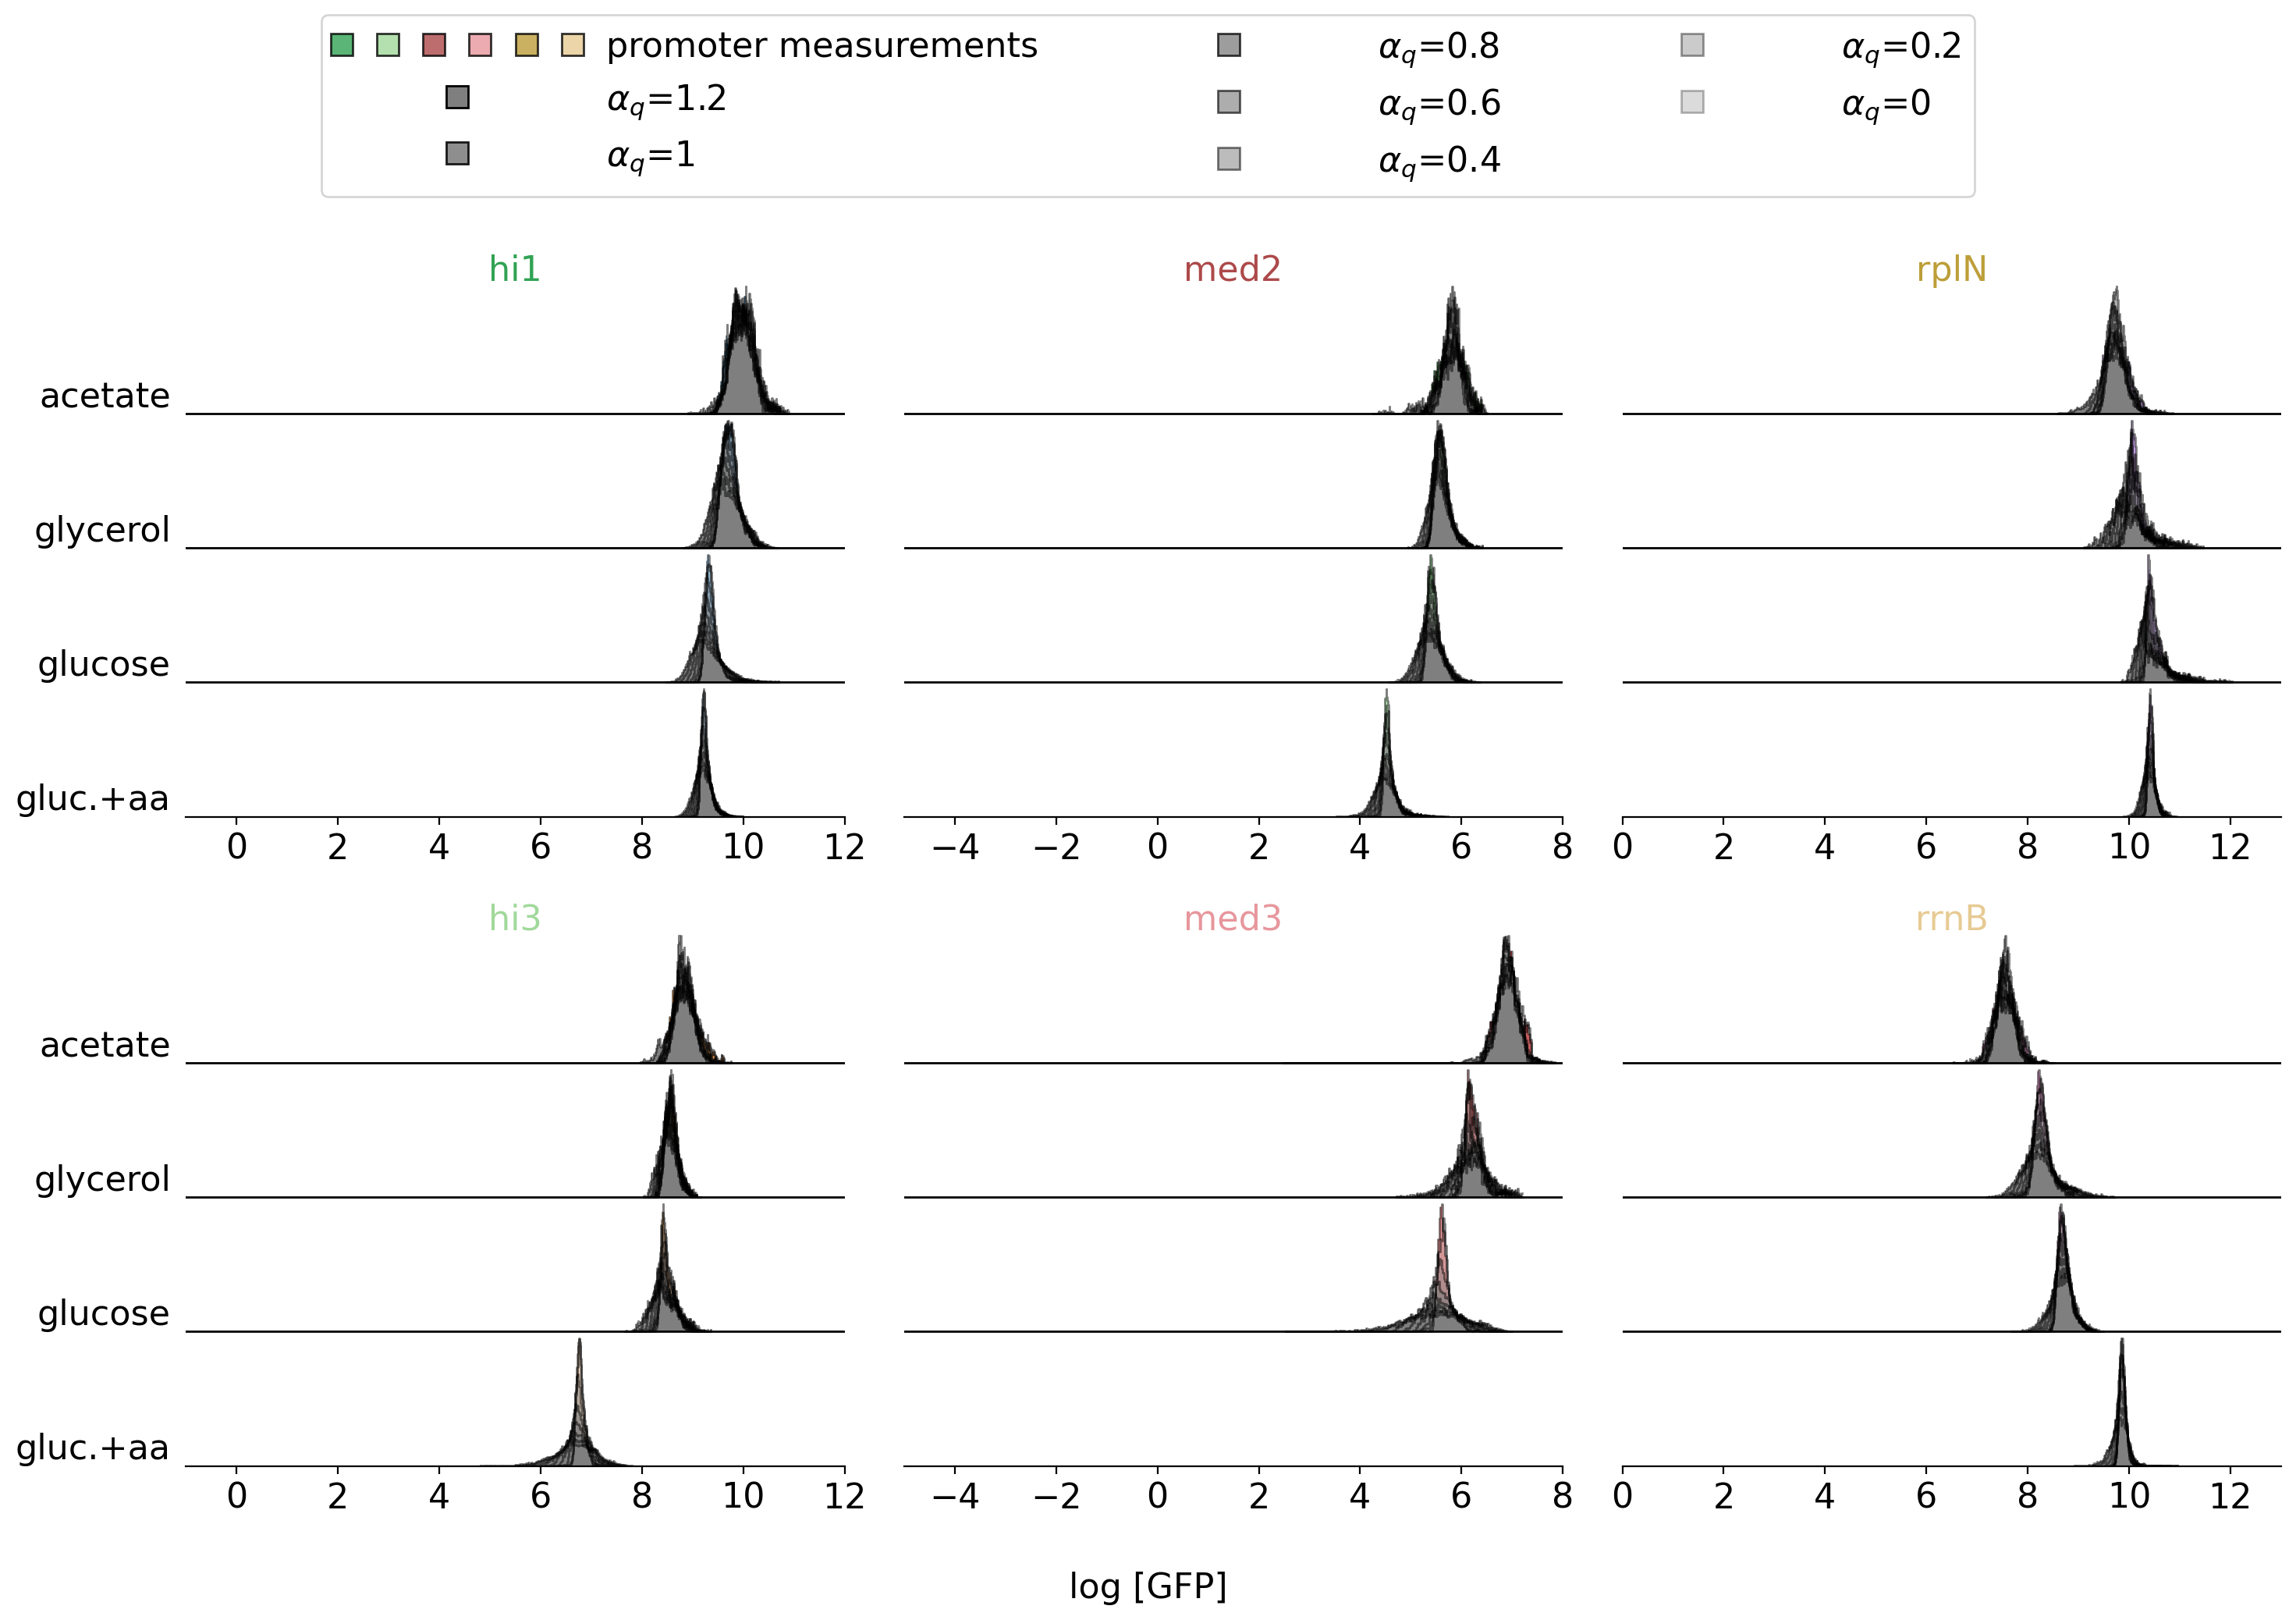

In [7]:
def plot_log_concentration_histograms_v(samples, hist_width=1, bins=30, plot_file=None, noise_settings=[]):
    fig, axes = plt.subplots(2, 3, figsize=(15, 9), sharex=False, sharey=True)
    ax = axes.transpose().ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["left"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.spines['left'].set_color('none')
        a.yaxis.tick_left()
        a.yaxis.set_ticks_position('none') 

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[2].get_shared_x_axes().join(ax[2], ax[3])
    ax[4].get_shared_x_axes().join(ax[4], ax[5])


    condition_xtick = {cond: m for cond,m  in zip(conditions, np.arange(4)[::-1])}

    for i, promoter in enumerate(promoters):
        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            color = color_by_both[samples[sample]["promoter"]][samples[sample]["condition"]]
            ###
            all_conc = np.concatenate([get_finite_log_concentrations(samples[sample][s]) for s in noise_settings])
            bins = np.linspace(np.min(all_conc), np.max(all_conc), 200)

            bins_list = []
            edges_list = []
            for s in noise_settings:
                b, e = np.histogram(get_finite_log_concentrations(samples[sample][s]), bins=bins)
                bins_list.append(b)
                edges_list.append(e)
            ###
            bin_norm = np.max([np.max(b) for b in bins_list])
            for j, b in enumerate(bins_list):
                bins_list[j]=b/bin_norm*hist_width

            # x = samples[sample]["mean_growth_rate"]*60
            x = condition_xtick[samples[sample]["condition"]]
            ax[i].bar(edges_list[0][:-1] + np.diff(edges_list[0]), bins_list[0], np.diff(edges_list[0]), bottom=x, lw = 2, alpha=0.8, color=color)
            ax[i].step(edges_list[0][:-1] + np.diff(edges_list[0]), x+bins_list[0], where="mid",  lw = 1, alpha=0.5, color="black")


            # ax[i].bar(edges_list[1][:-1] + np.diff(edges_list[1]), bins_list[1], np.diff(edges_list[1]), bottom=x, lw = 2, alpha=0, color="None")
            # ax[i].step(edges_list[1][:-1] + np.diff(edges_list[1]), x+bins_list[1], where="mid",  lw = 1, alpha=0.5, color="black")


            for j, s in enumerate(noise_settings):
                if s== "cells" or s=="cells_no_div_no_prod_noise":
                    continue
                ax[i].bar(edges_list[j][:-1] + np.diff(edges_list[j]), bins_list[j], np.diff(edges_list[j]), bottom=x, lw = 2, alpha=alpha_by_setting[s], color="tab:grey")
                ax[i].step(edges_list[j][:-1] + np.diff(edges_list[j]), x+bins_list[j], where="mid",  lw = 1, alpha=0.5, color="black")
        

            ax[i].axhline(x, lw=1, color="black", alpha=1)
            ax[i].set_yticks([])
            ax[i].set_title(promoter, y=0.94, color=color_by_promoter[promoter])
            ax[i].set_yticks(np.arange(4)[::-1], )
            ax[i].set_yticklabels( conditions_labels, fontdict={'verticalalignment':"bottom"})
            ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=2))


    ax[0].set_xlim([-1, 12])
    ax[2].set_xlim([-5, 8])
    ax[4].set_xlim([-0, 13])

    colors_for_legend1 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],
                                        alpha=0.8, 
                                        markersize=10,
                                        marker='s',
                                        linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]
    
    colors_for_legend2 = [mlines.Line2D([], [],  alpha=alpha_by_setting[s], 
                                        markersize=10,
                                        marker='s',
                                       linestyle='None',
                                       markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                       color='tab:grey', 
                                       label=get_q_scale_label(s)) for s in noise_settings if s in alpha_by_setting.keys() ]
    
    colors_for_legend3 = [mlines.Line2D([], [], 
                                        markersize=10,
                                        color="None", 
                                        markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        marker='s',linestyle='None', label=l) for l in ["no div. noise"]]
    
    from matplotlib.legend_handler import HandlerTuple
    # l = fig.legend([ tuple(colors_for_legend1),
    #                 tuple(colors_for_legend3)]+
    #                 [(c,) for i,c in enumerate(colors_for_legend2)] , 
    #                ['promoter measurements'] +["no div. noise"]+ [get_q_scale_label(s) for s in noise_settings if s in alpha_by_setting.keys()] ,
    #                 handler_map={tuple: HandlerTuple(ndivide=None, pad=1)}, 
    #                 bbox_to_anchor=(0.5, 1), 
    #                 loc="lower center", 
    #                 ncol=4, 
    #                 scatterpoints = len(promoters), 
    #                 scatteryoffsets = [.5], handlelength = len(promoters)+1)  

    l = fig.legend([ tuple(colors_for_legend1) ]+
                    [(c,) for i,c in enumerate(colors_for_legend2)] , 
                   ['promoter measurements'] + [get_q_scale_label(s) for s in noise_settings if s in alpha_by_setting.keys()] ,
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=1)}, 
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", 
                    ncol=3, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = len(promoters)+1)  
    
    fig.supxlabel("log [GFP]")

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()


# setting_to_compare = ["cells"]+["cells_"+s for s in ["0.32", "0.1", "0.032", "0.01", "0.0032"]]
setting_to_compare = ["cells_no_div_no_prod_noise"]+["cells_"+s for s in ['1.2', '1','0.8','0.6','0.4','0.2','0']]
    
plot_log_concentration_histograms_v(first_replicates, hist_width=0.95, 
                                    noise_settings=setting_to_compare,
                                    plot_file=None)



In [8]:
### Statistics
#### concentration
def get_mean_concentration(cells):
    return np.mean(get_concentrations(cells))

def get_log_concentration_mean(cells):
    return np.mean( get_finite_log_concentrations(cells) )

def get_log_concentration_std(cells):
    return np.std( get_finite_log_concentrations(cells) )


def get_log_concentration_iqr(cells):
    return estimate_iqr( get_finite_log_concentrations(cells) )

def get_log_gfp_mean(cells):
    return np.mean( get_finite_log_gfp(cells) )


def estimate_iqr(c):
    return np.subtract(*np.percentile(c, [75, 25]))


#### gfp
def get_mean_division_gfp(cells):
    g = []
    for cell in cells:
        g.append(cell.gfp[-1])
    return np.mean(g)

def get_gfp_mean(cells):
    return np.mean( get_gfp(cells) )


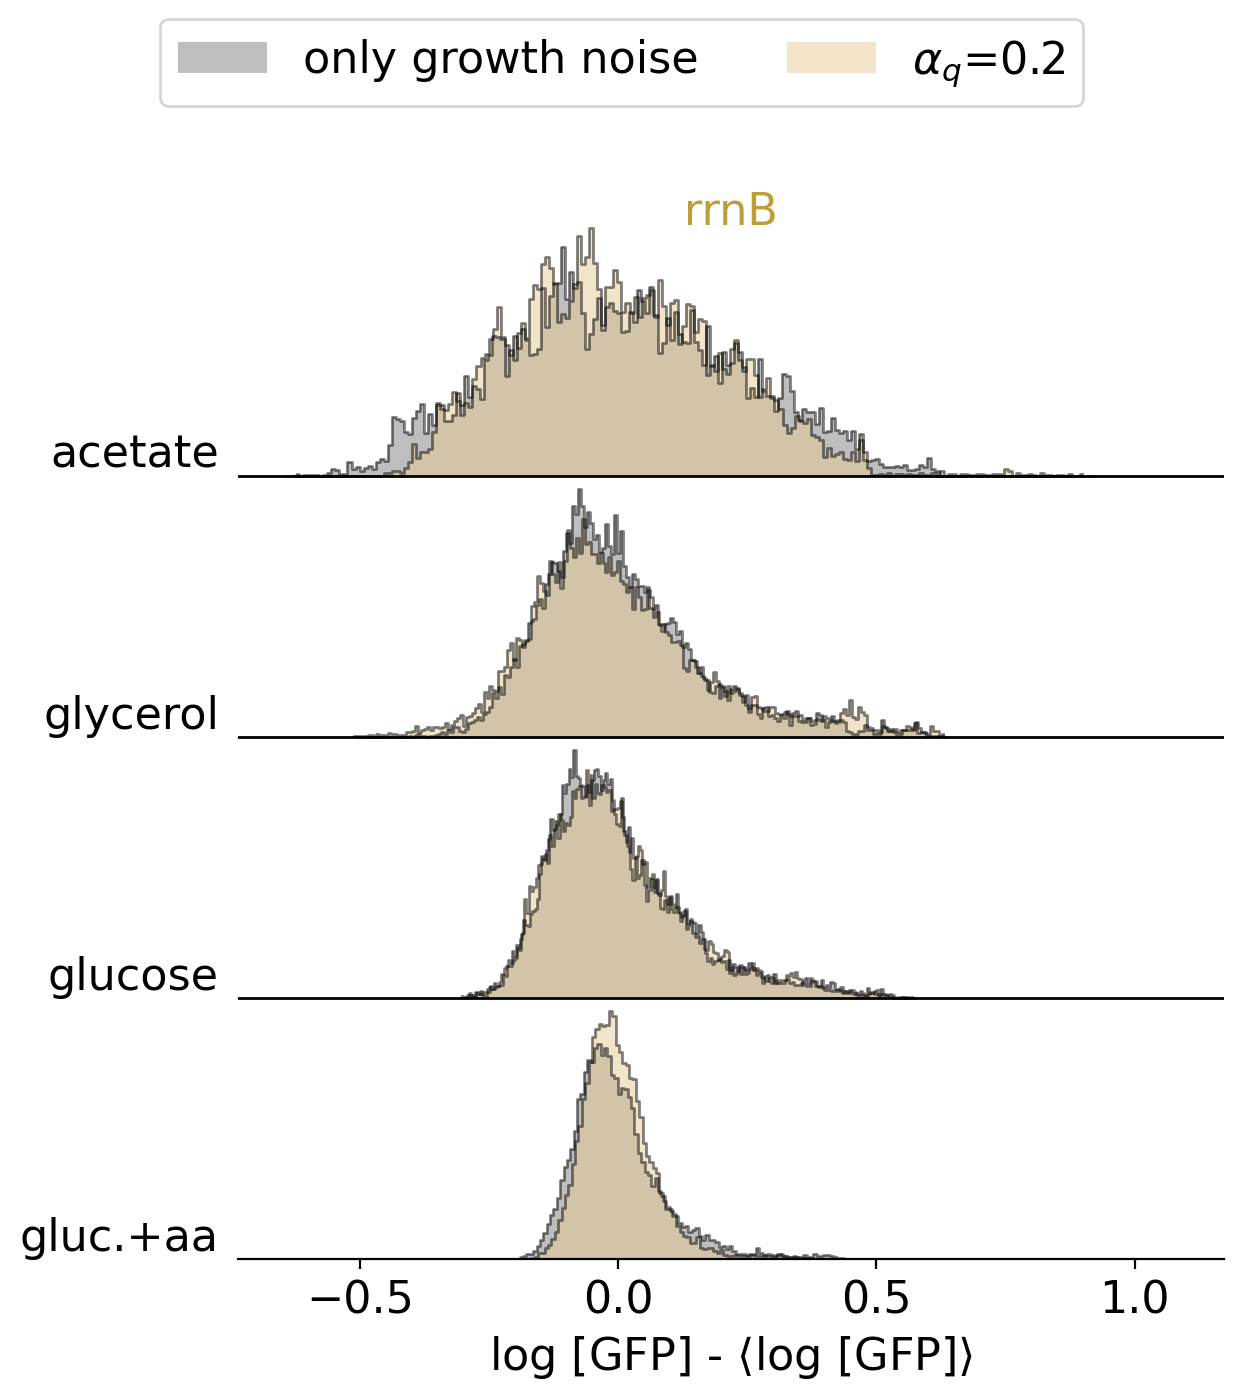

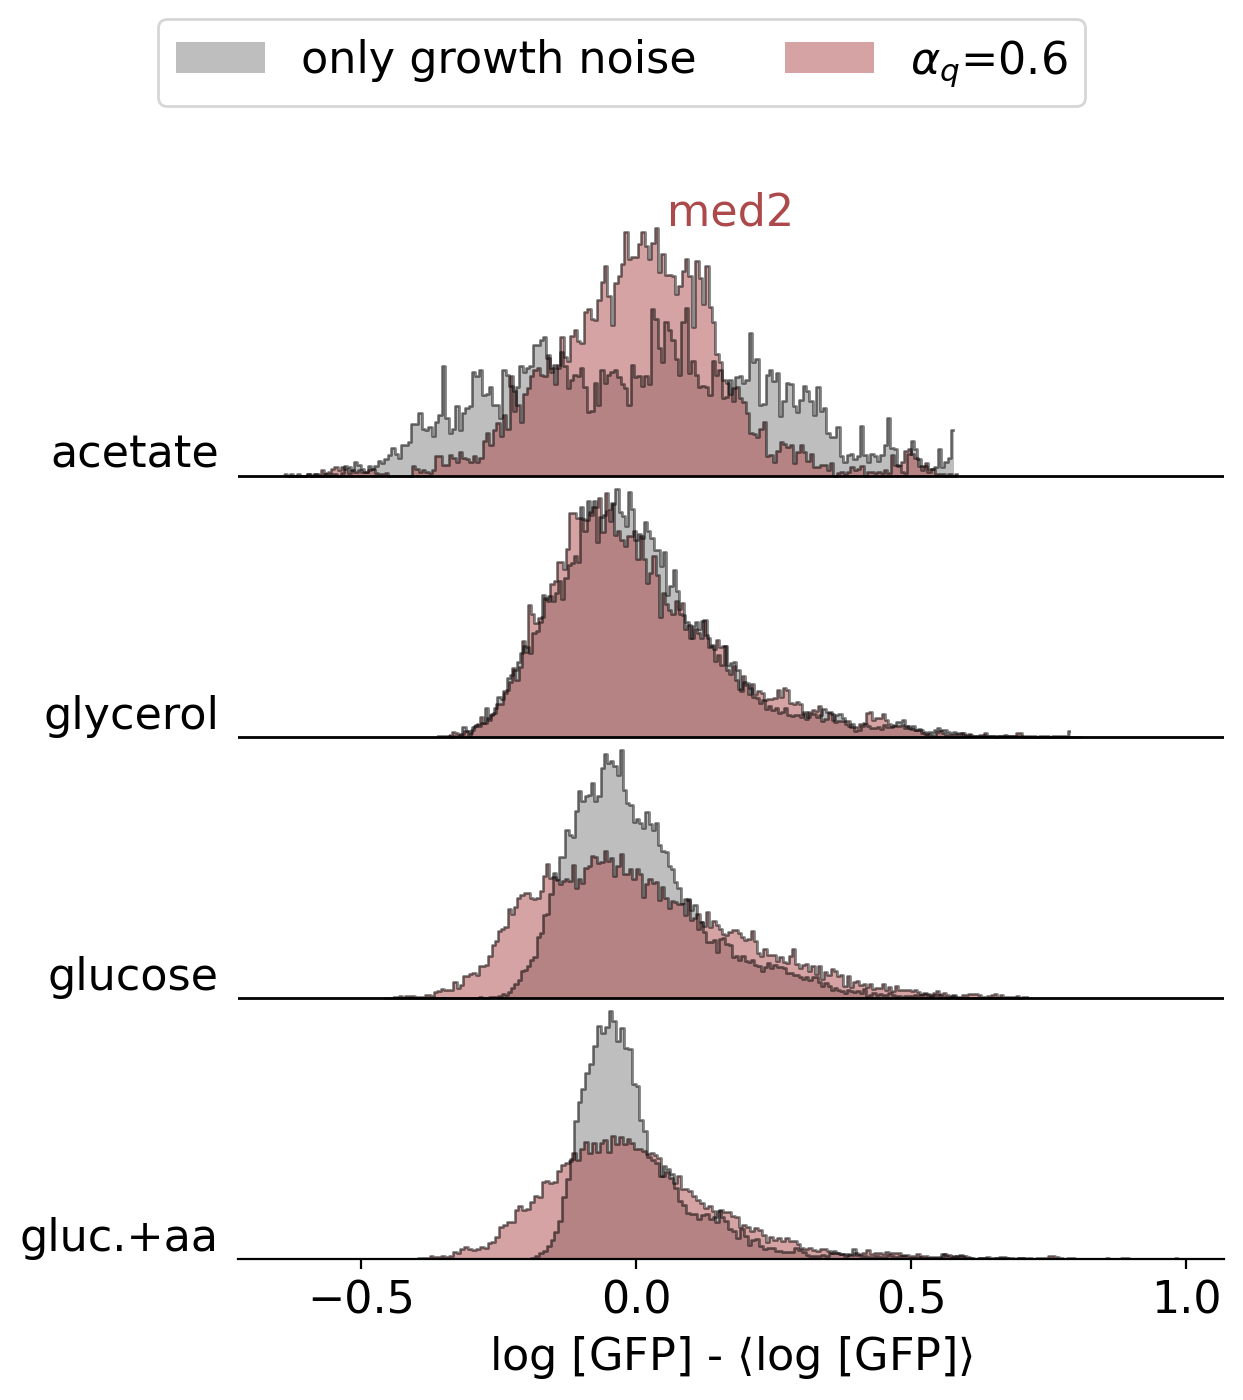

In [9]:
def plot_log_concentration_histograms_v_example(samples, promoter, hist_width=1, bins=30, plot_file=None, noise_settings=[]):
    fig, axes = plt.subplots(1,1, figsize=(FULL_SIZE/2, FULL_SIZE/2), sharex=False, sharey=True)
    # ax = axes.transpose().ravel()
    ax = [axes]
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["left"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.spines['left'].set_color('none')
        a.yaxis.tick_left()
        a.yaxis.set_ticks_position('none') 



    condition_xtick = {cond: m for cond,m  in zip(conditions, np.arange(4)[::-1])}
    label0 = "only growth noise"
    label1 = get_q_scale_label(noise_settings[-1].split("_")[-1])
    for i, promoter in enumerate([promoter]):
        for sample in samples.keys():
            if samples[sample]["promoter"] != promoter:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]
            ###
            all_conc = np.concatenate([get_finite_log_concentrations(samples[sample][s]) for s in noise_settings])
            bins = np.linspace(np.min(all_conc), np.max(all_conc), 200)

            bins_list = []
            edges_list = []
            for s in noise_settings:
                conc = get_finite_log_concentrations(samples[sample][s])
                b, e = np.histogram(conc, 
                                    bins=bins)
                bins_list.append(b)
                edges_list.append(e-np.mean(conc))
            ###
            bin_norm = np.max([np.max(b) for b in bins_list])
            for j, b in enumerate(bins_list):
                bins_list[j]=b/bin_norm*hist_width

            # x = samples[sample]["mean_growth_rate"]*60
            x = condition_xtick[samples[sample]["condition"]]
            x_label = label_by_condition[samples[sample]["condition"]]
            j = 0
            s = noise_settings[j]
            ax[i].bar(edges_list[j][:-1] + np.diff(edges_list[j]), 
                      bins_list[j], np.diff(edges_list[j]), 
                      bottom=x, lw = 2, 
                      alpha=0.5, color="tab:grey",
                      label=label0)
            label0=None
                      
            ax[i].step(edges_list[0][:-1] + np.diff(edges_list[0]), x+bins_list[0], where="mid",  lw = 1, alpha=0.5, color="black")

            j = 1
            s = noise_settings[j]
            
            ax[i].bar(edges_list[j][:-1] + np.diff(edges_list[j]), bins_list[j], np.diff(edges_list[j]), 
                      bottom=x, 
                      lw = 2, 
                      alpha=0.5, 
                      color=color, 
                      label=label1)
            ax[i].step(edges_list[j][:-1] + np.diff(edges_list[j]), x+bins_list[j], where="mid",  lw = 1, alpha=0.5, color="black")
            label1=None


            ax[i].axhline(x, lw=1, color="black", alpha=1)
            ax[i].set_yticks([])
            ax[i].set_title(promoter, y=0.94, color=color_by_promoter_cat[promoter])
            ax[i].set_yticks(np.arange(4)[::-1], )
            ax[i].set_yticklabels( conditions_labels, fontdict={'verticalalignment':"bottom"})
            ax[i].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=0.5))

    fig.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center')

    ax[0].set_xlabel(r"log [GFP] - $\langle$log [GFP]$\rangle$")

    plt.tight_layout()
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    plt.show()


# setting_to_compare = ["cells"]+["cells_"+s for s in ["0.32", "0.1", "0.032", "0.01", "0.0032"]]
setting_to_compare = ["cells_no_div_no_prod_noise"]+["cells_"+s for s in [ '0.2']]
       
plot_log_concentration_histograms_v_example(first_replicates, 'rrnB', hist_width=0.95, 
                                    noise_settings=setting_to_compare,
                                    plot_file="../../figures_for_fluctuations_paper/supp/scaled_dq_hist_rrnB.pdf") 


setting_to_compare = ["cells_no_div_no_prod_noise"]+["cells_"+s for s in [ '0.6']]

plot_log_concentration_histograms_v_example(first_replicates, 'med2', hist_width=0.95, 
                                    noise_settings=setting_to_compare,
                                    plot_file="../../figures_for_fluctuations_paper/supp/scaled_dq_hist_med2.pdf") 





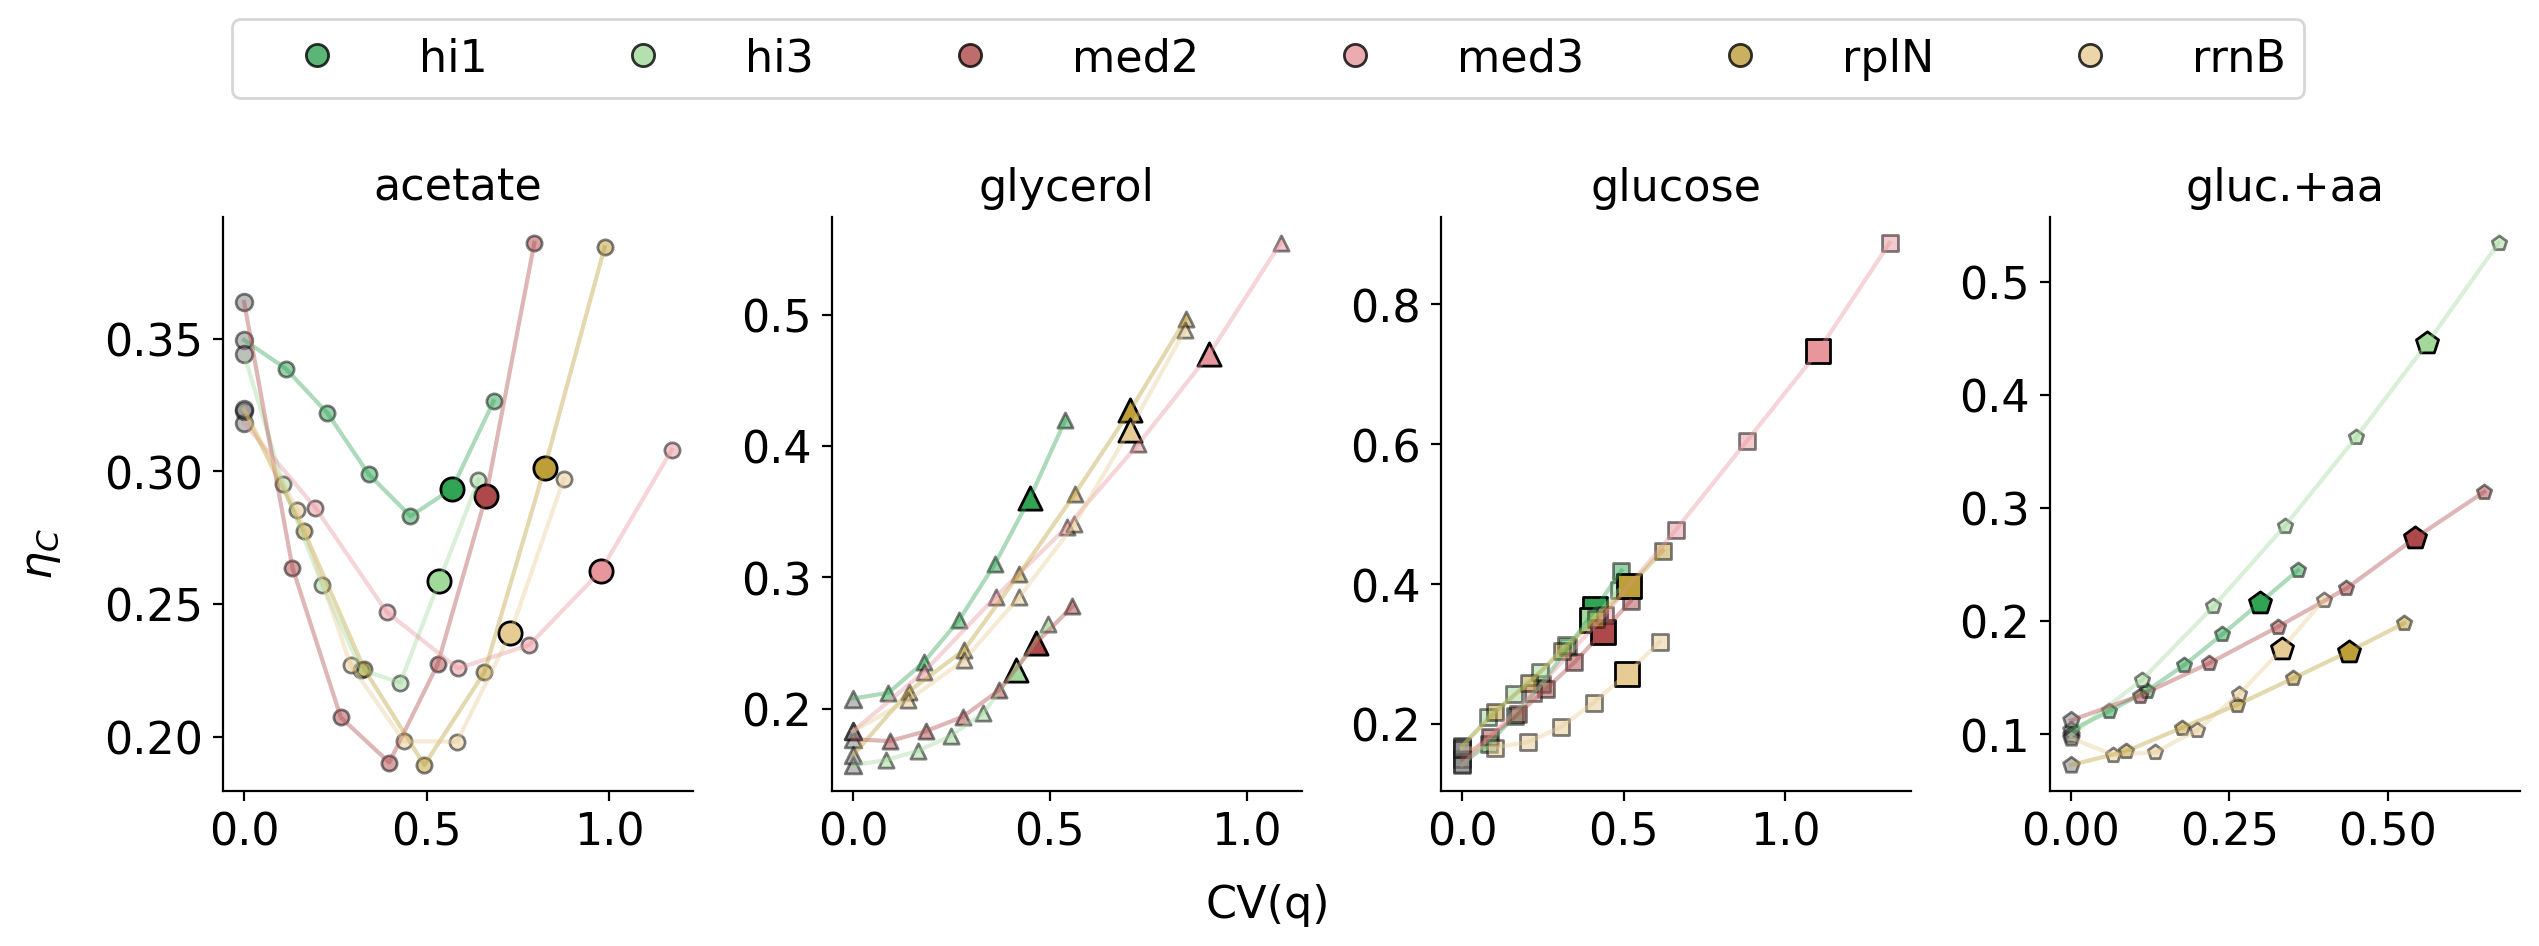

In [10]:
def plot_log_concentration_iqr_single(samples, noise_settings=[], plot_file=None):
    fig, axes = plt.subplots(1, 4, figsize=(FULL_SIZE, FULL_SIZE/3.), sharex=False, sharey=False)
    ax = axes.ravel()

    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        # a.set_yscale('log')
    
    for i, condition in enumerate(conditions):
        iqrs_prod_noise={}
        cvs={}

        for sample in samples.keys():
            if samples[sample]["condition"] != condition:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]
            marker = marker_by_condition[samples[sample]["condition"]]
            ###
            iqrs=[]

            for j, s in enumerate(noise_settings):    
                iqr = get_log_concentration_iqr(samples[sample][s])
                iqrs.append(iqr)
            for j, s in enumerate(noise_settings):       
                if j==0:
                    ax[i].scatter(0, iqrs[j], alpha=0.5, 
                                  marker=marker_by_condition[condition],
                                  color="tab:grey", ec=list(mcolors.to_rgb('black')) + [0.5], 
                                  label=samples[sample]["promoter"])
                    cvs[samples[sample]["promoter"]] = [0]
                    pass
                else:
                    if s == 'cells_1':
                        alpha =1
                        size=70
                    else:
                        alpha=0.5
                        size = 30
                    cv = samples[sample]["q_cv"]*float(s.split("_")[-1])
                    ax[i].scatter(cv, iqrs[j], alpha=alpha, 
                                  marker=marker_by_condition[condition],
                                  color=color, 
                                  s=size,
                                  ec=list(mcolors.to_rgb('black')) + [1], 
                                  label=get_q_scale_label(s))
                    cvs[samples[sample]["promoter"]].append(cv)
                    
            iqrs_prod_noise[samples[sample]["promoter"]] = iqrs
            
            ax[i].set_title(label_by_condition[condition], y=1)
        for p in cvs.keys():  
            ax[i].plot(cvs[p], iqrs_prod_noise[p], color=color_by_promoter[p], alpha=0.4)
    
    colors_for_legend2 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],alpha=0.8, markersize=8,marker='o',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]

    l = fig.legend([tuple(colors_for_legend2[i:i+1]) for i in range(6)], 
                    promoters,
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", 
                    ncol=6, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = 3)   
    
    fig.supylabel(r"$\eta_C$")
    fig.supxlabel(r"CV(q)", y=0.07)

    plt.tight_layout()
    fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')

    plt.show()
    

setting_to_compare = ["cells_no_div_no_prod_noise"] + ["cells_"+s for s in ['1.2', '1','0.8','0.6','0.4','0.2'][::-1]]
plot_log_concentration_iqr_single(first_replicates, noise_settings=setting_to_compare,
                                    plot_file="../../figures_for_fluctuations_paper/supp/scaled_dq_iqr.pdf") 


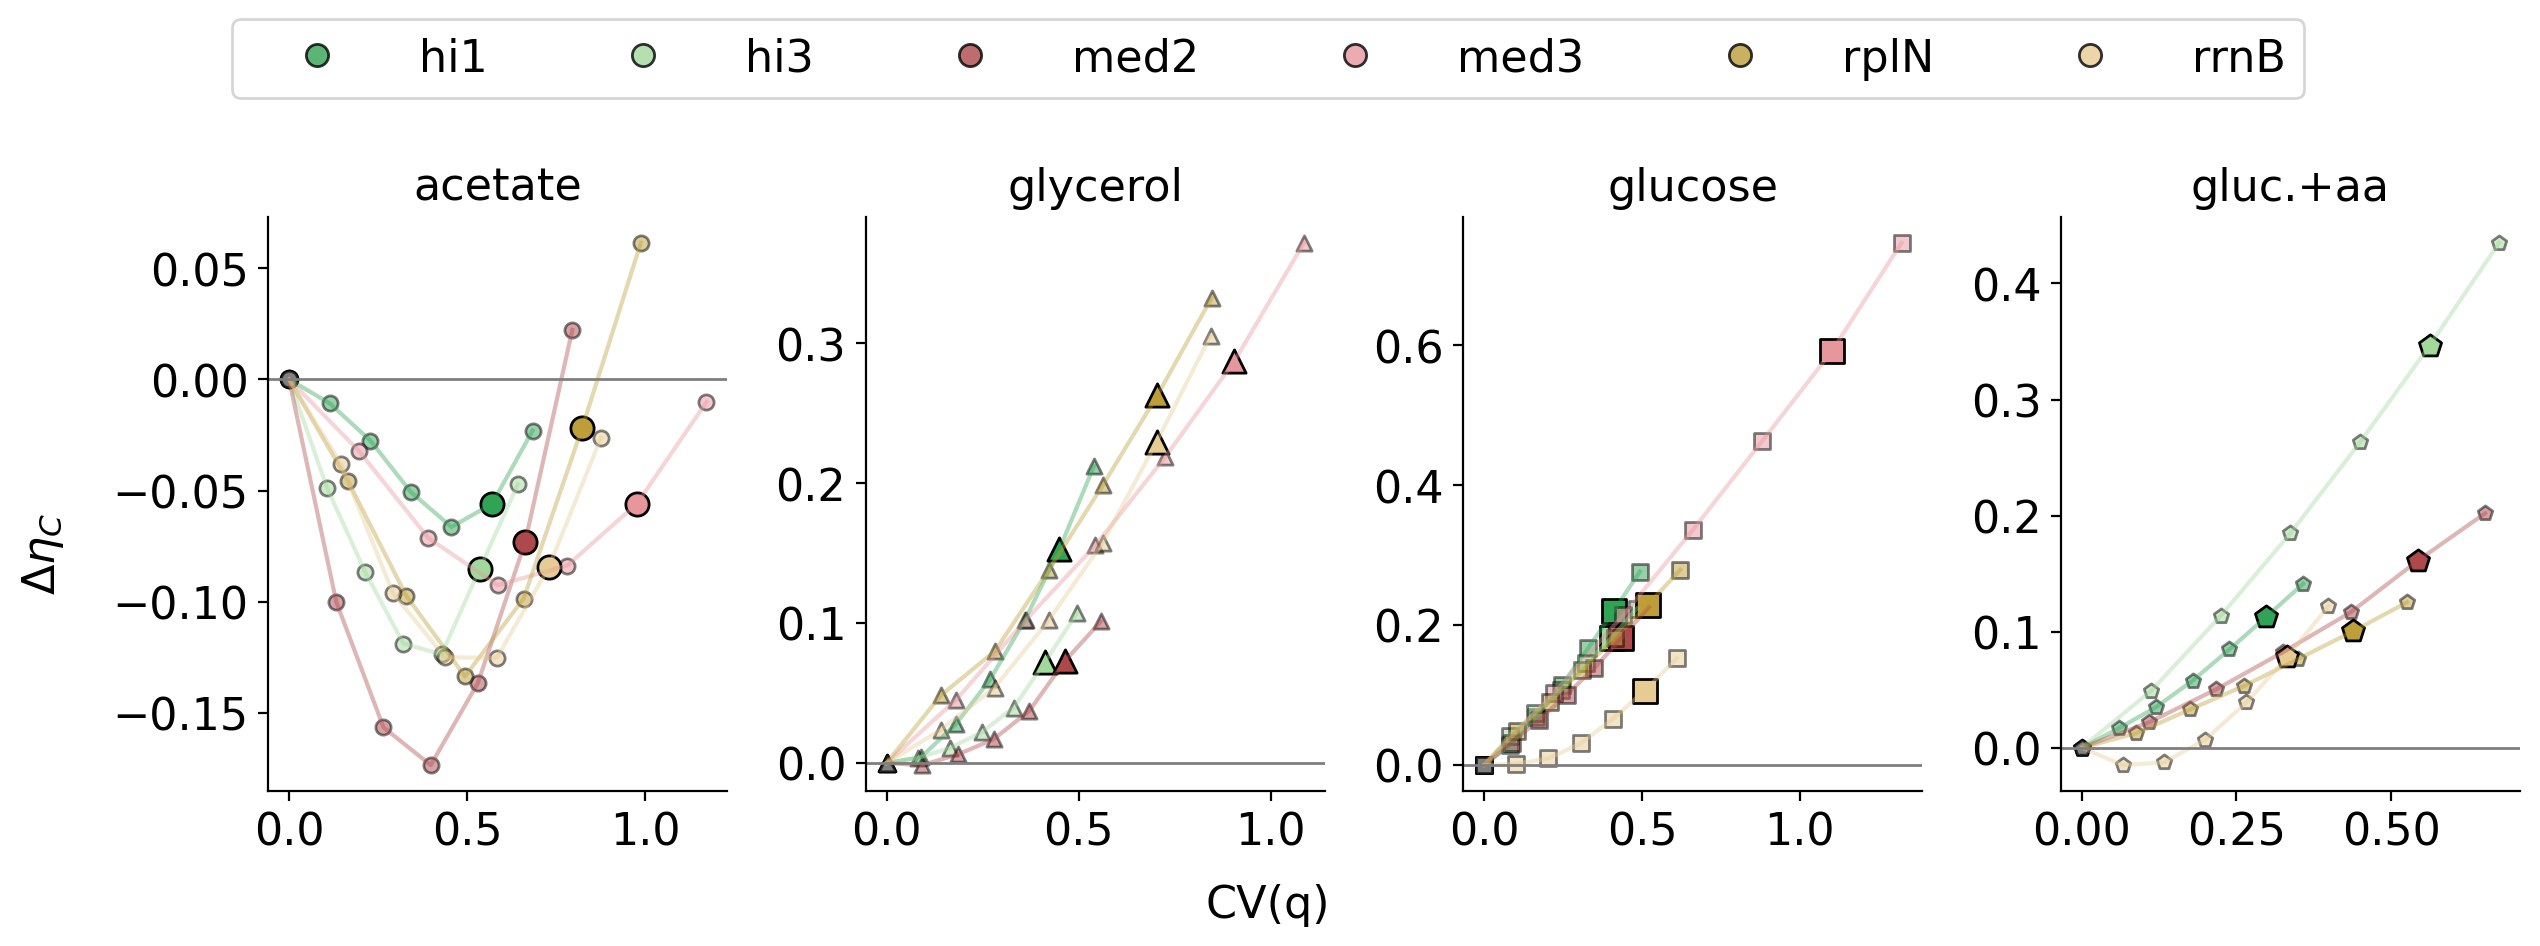

In [11]:
def plot_log_concentration_iqr_relative(samples, noise_settings=[], plot_file=None):
    fig, axes = plt.subplots(1, 4, figsize=(FULL_SIZE, FULL_SIZE/3.), sharex=False, sharey=False)
    ax = axes.ravel()

    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()
        # a.set_yscale('log')
    
    for i, condition in enumerate(conditions):
        iqrs_prod_noise={}
        cvs={}

        for sample in samples.keys():
            if samples[sample]["condition"] != condition:
                continue
            color = color_by_promoter[samples[sample]["promoter"]]
            marker = marker_by_condition[samples[sample]["condition"]]
            ###
            iqrs=[]

            for j, s in enumerate(noise_settings):    
                iqr = get_log_concentration_iqr(samples[sample][s])
                iqrs.append(iqr)
            iqrs = np.array(iqrs)
            iqrs = iqrs - iqrs[0]
            for j, s in enumerate(noise_settings):       
                if j==0:
                    ax[i].scatter(0, iqrs[j], alpha=0.5, 
                                  marker=marker_by_condition[condition],
                                  color="tab:grey", ec=list(mcolors.to_rgb('black')) + [0.5], 
                                  label=samples[sample]["promoter"])
                    cvs[samples[sample]["promoter"]] = [0]
                    pass
                else:
                    if s == 'cells_1':
                        alpha =1
                        size=70
                    else:
                        alpha=0.5
                        size = 30
                    cv = samples[sample]["q_cv"]*float(s.split("_")[-1])
                    ax[i].scatter(cv, iqrs[j], alpha=alpha, 
                                  marker=marker_by_condition[condition],
                                  color=color, 
                                  s=size,
                                  ec=list(mcolors.to_rgb('black')) + [1], 
                                  label=get_q_scale_label(s))
                    cvs[samples[sample]["promoter"]].append(cv)
                    
            iqrs_prod_noise[samples[sample]["promoter"]] = iqrs
            
            ax[i].set_title(label_by_condition[condition], y=1)
        for p in cvs.keys():  
            ax[i].plot(cvs[p], iqrs_prod_noise[p], color=color_by_promoter[p], alpha=0.4)
        ax[i].axhline(0, c="tab:grey", lw=1)
    colors_for_legend2 = [mlines.Line2D([], [],markeredgecolor=list(mcolors.to_rgb('black')) + [0.5], 
                                        color=color_by_promoter[k],alpha=0.8, markersize=8,marker='o',linestyle='None',
                                        label=k) for k in color_by_promoter.keys()]

    l = fig.legend([tuple(colors_for_legend2[i:i+1]) for i in range(6)], 
                    promoters,
                    handler_map={tuple: HandlerTuple(ndivide=None, pad=0.5)}, 
                    bbox_to_anchor=(0.5, 1), 
                    loc="lower center", 
                    ncol=6, 
                    scatterpoints = len(promoters), 
                    scatteryoffsets = [.5], handlelength = 3)   
    
    fig.supylabel(r"$\Delta\eta_C$")
    fig.supxlabel(r"CV(q)", y=0.07)

    plt.tight_layout()
    fig.savefig(plot_file, facecolor="white", bbox_inches='tight')
    if plot_file !=None:
        fig.savefig(plot_file, facecolor="white", bbox_inches='tight')

    plt.show()
    

setting_to_compare = ["cells_no_div_no_prod_noise"] + ["cells_"+s for s in ['1.2', '1','0.8','0.6','0.4','0.2'][::-1]]
plot_log_concentration_iqr_relative(first_replicates, noise_settings=setting_to_compare,
                                    plot_file="../../figures_for_fluctuations_paper/supp/scaled_dq_iqr_relative.pdf") 
